In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
df = pd.read_csv("dataset/processed/traffic-weather-data.csv")
df.shape

(57720, 17)

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

In [4]:
df.head()

,Total Volume,Year,Day,sin_Month,cos_Month,sin_DayOfWeek,cos_DayOfWeek,sin_Hour,cos_Hour,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
Datetime,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,69.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.000000,1.000000,11.7,78,0.0,0.0,0.0,1,18.5
2013-06-01 01:00:00,33.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.258819,0.965926,10.9,80,0.0,0.0,0.0,0,17.9
2013-06-01 02:00:00,23.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.500000,0.866025,10.2,81,0.0,0.0,0.0,0,17.6
2013-06-01 03:00:00,24.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.707107,0.707107,9.5,80,0.0,0.0,0.0,0,16.7
2013-06-01 04:00:00,26.0,2013,1,1.224647e-16,-1.0,-0.974928,-0.222521,0.866025,0.500000,8.9,79,0.0,0.0,0.0,0,16.1


### Train test split & normalize

In [5]:
split_from = "2019-03-01 00:00:00"

train = df[df.index<split_from]
test = df[df.index>=split_from]

print(train.shape, test.shape)

(50376, 16) (7344, 16)


<AxesSubplot:xlabel='Datetime'>

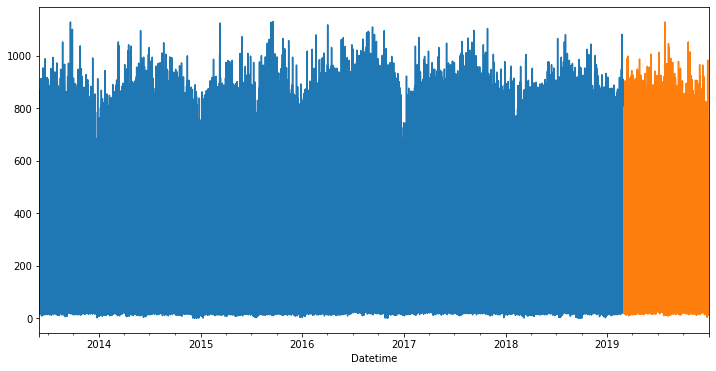

In [6]:
plt.figure(figsize=(12,6))
train['Total Volume'].plot()
test['Total Volume'].plot()

In [7]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [8]:
with open('saved/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [9]:
scaled = np.vstack((train_scaled, test_scaled))

In [10]:
np.shape(scaled), np.shape(train_scaled), np.shape(test_scaled)

((57720, 16), (50376, 16), (7344, 16))

In [11]:
take_n_dates_past = 7
forecast_n_dates_future = 2

n_past = 24*take_n_dates_past
n_future = 24*forecast_n_dates_future

In [12]:
X_sequences, y_sequences = [], []

for i in range(n_past, len(scaled)-n_future+1):
    X_sequences.append(scaled[i-n_past:i])
    y_sequences.append([scaled[i+n_future-1][0]])

In [13]:
np.shape(X_sequences), np.shape(y_sequences)

((57505, 168, 16), (57505, 1))

In [14]:
test_len = len(test_scaled)

X_train = np.array(X_sequences[:-test_len])
y_train = np.array(y_sequences[:-test_len])

X_test = np.array(X_sequences[-test_len:])
y_test = np.array(y_sequences[-test_len:])

In [15]:
np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

((50161, 168, 16), (50161, 1), (7344, 168, 16), (7344, 1))

### Modelling

In [16]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
first_lstm_layer = LSTM(units=64, return_sequences=True, activation='relu')(input_layer)
second_lstm_layer = LSTM(units=32, return_sequences=False, activation='relu')(first_lstm_layer)
output_layer = Dense(units=y_train.shape[1], activation='linear')(second_lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 16)]         0         
                                                                 
 lstm (LSTM)                 (None, 168, 64)           20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33,185
Trainable params: 33,185
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_checkpoint = ModelCheckpoint(f'saved/model.h5', 
                             monitor='val_loss',   # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             mode='min'            # Mode of monitoring (minimize validation loss)
                            )

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=1,
                               restore_best_weights=True
                              )

In [18]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
 587/2508 [======>.......................] - ETA: 13:17 - loss: 0.0178

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

### Evaluating

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:340])
plt.plot(y_pred[:340])

### Training with entire data

In [19]:
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [20]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
first_lstm_layer = LSTM(units=64, return_sequences=True, activation='relu')(input_layer)
second_lstm_layer = LSTM(units=32, return_sequences=False, activation='relu')(first_lstm_layer)
output_layer = Dense(units=y_train.shape[1], activation='linear')(second_lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 168, 16)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 168, 64)           20736     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 33,185
Trainable params: 33,185
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_checkpoint = ModelCheckpoint(f'saved/model.h5', 
                             monitor='val_loss',   # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             mode='min'            # Mode of monitoring (minimize validation loss)
                            )

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=1,
                               restore_best_weights=True
                              )

In [ ]:
full_history = model.fit(X_sequences, y_sequences, epochs=10, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
2876/2876 [==============================] - 2669s 927ms/step - loss: 0.0080 - val_loss: 0.0045
Epoch 2/10
 325/2876 [==>...........................] - ETA: 1:16:30 - loss: 0.0044